In [56]:
import pandas as pd
import numpy as np
import torch
import os
torch.set_num_threads(os.cpu_count())
from torch import optim as optim
from torch import nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [57]:
transform = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=128, shuffle=True, num_workers=os.cpu_count())
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False, num_workers=os.cpu_count())



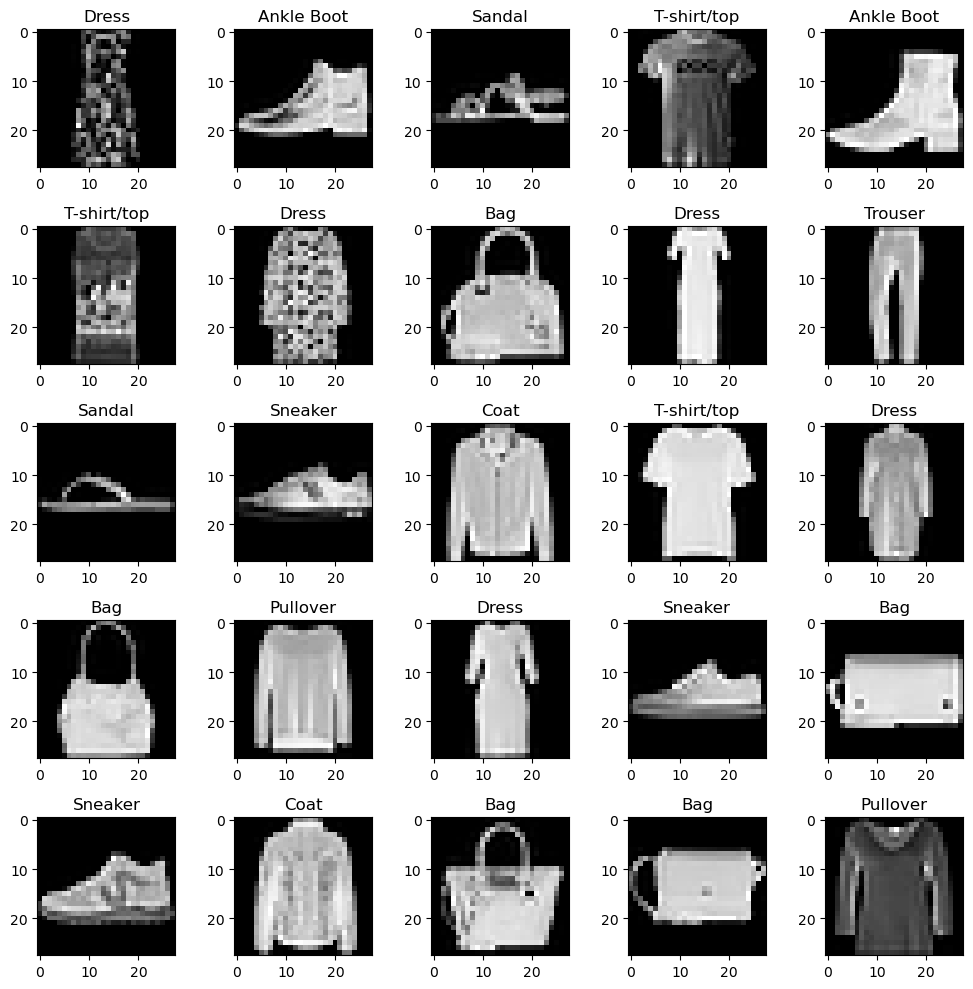

In [3]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')
batch = next(iter(training_loader))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(*batch)):
    if i > 24:
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()

In [64]:
print(image.shape)

torch.Size([1, 28, 28])


In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Model

In [75]:
class CNN(nn.Module):
    def __init__(self, image_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1)
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            flatten_dim = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flatten_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [76]:
model = CNN(image_channels=1, num_classes=10).to(device)

In [77]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [78]:
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss()

def train_model(model, optimizer, training_loader, criterion=loss_fn, no_epochs=5):
    model.train()
    batches = []
    losses = []
    j = 0

    for epoch in range(no_epochs):  # Don't wrap this with tqdm
        running_loss = 0
        correct = 0
        total = 0

        loop = tqdm(enumerate(training_loader), total=len(training_loader), desc=f"Epoch {epoch+1}/{no_epochs}")

        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()    
            optimizer.step()  
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm with current metrics
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

            if i % 100 == 99:
                avg_loss = running_loss / 100
                losses.append(avg_loss)
                j += i
                batches.append(j)
                print(f"Epoch: {epoch}, Batch: {i+1}, Loss: {avg_loss:.3f}, Accuracy: {100 * correct / total:.2f}%")
                running_loss = 0

        if epoch % 2 == 0:
            print(f"Epoch {epoch+1} completed")

    return model, losses, batches


In [79]:
def plot_loss(losses, batches):
    plt.plot(batches, losses)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.title('Loss vs. Batches')
    plt.show()

In [80]:
model1, losses, batches = train_model(model, optimizer, training_loader, loss_fn, no_epochs=3)

Epoch 1/3:   3%|▎         | 16/469 [00:30<14:34,  1.93s/it, accuracy=54.9, loss=0.769]


KeyboardInterrupt: 

In [73]:
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0   # Counter for correctly classified samples
    total = 0     

   
    with torch.no_grad():  
        for images, labels in loader:
            images = images.view(-1, 28 * 28)  # Iterate through the DataLoader
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            
            # Update total sample count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")

In [ ]:
plt.figure(figsize=(10, 5))
plot_loss(losses, batches)

In [74]:
evaluate_model(model1, validation_loader)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 784]